# I. Intro to LightGBM


In [1]:
import gc
import os
import math
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score, roc_curve
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import lightgbm as lgb
import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
import seaborn as sns

## Credit Default Dataset

In [2]:
df = pd.read_excel('data/credit-default.xls', header = 1)

In [3]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
df.shape

(30000, 25)

List of columns

In [5]:
[*df]

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

Explanation:
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
- X2: Gender (1 = male; 2 = female).
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
- X4: Marital status (1 = married; 2 = single; 3 = others).
- X5: Age (year).
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
- X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.


### Objective: Predict `default payment next month`

In [6]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


**Exercise**: Do data treatment with Pandas

In [36]:
X = df.copy()
X["total_paid"] = X.iloc[:, 18:24].sum(axis=1)
X["mean_bill_amnt"] = X.iloc[:, 12:18].mean(axis=1).round(decimals=2)
y = X["default payment next month"]
X = X.drop(columns=["default payment next month"])

In [38]:
X.head()

0        1
1        1
2        0
3        0
4        0
        ..
29995    0
29996    0
29997    1
29998    1
29999    1
Name: default payment next month, Length: 30000, dtype: int64

**Exercise:** Do some plots with Matplotlib

(array([1.9283e+04, 7.9670e+03, 2.0010e+03, 5.1200e+02, 1.5900e+02,
        6.7000e+01, 1.0000e+01, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-56043.17,  37292.53, 130628.23, 223963.93, 317299.63, 410635.33,
        503971.03, 597306.73, 690642.43, 783978.13, 877313.83]),
 <a list of 10 Patch objects>)

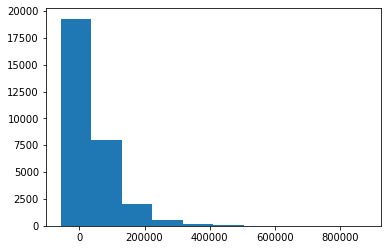

In [34]:
plt.hist(X["mean_bill_amnt"])


**Exercise**: Split train/test randomly 80/20, train LightGBM and plot feature-importance

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [41]:
def plot_feature_importance(feature_importance,title):
    fe = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)
    fe['feature'] = fe.index
    plt.figure(figsize=(16, 12))
    sns.barplot(x="importance", y="feature", data=fe)
    plt.xticks([])
    plt.title(title)
    return

In [42]:
def train_lgb(X_train, X_valid, y_train, y_valid, params=None):

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=['auc', 'binary_logloss'],
            verbose=1, early_stopping_rounds=50)

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)

    importance = pd.DataFrame()
    importance["feature"] = X.columns
    importance["importance"] = model.feature_importances_
    return y_pred_train, y_pred_valid, importance

In [43]:
def calc_accuracy(y_pred, y):
    return sum(y_pred == y)/len(y)

In [57]:
params = {
          'n_estimators': 500,  # Number of trees
          'num_leaves': 60,  # max number of leaves in tree
          'min_data_in_leaf': 2,
          'max_depth': -1,
          'learning_rate': 0.02,
          "boosting": "gbdt",
          "bagging_freq": 10,
          'num_threads': 8,
          "bagging_fraction": 0.7,
          "bagging_seed": 11,
          "metric": 'binary_logloss',
         }

In [46]:
y_pred_train, y_pred_test, feature_importance = train_lgb(X_train, X_test, y_train, y_test, params=params)

[1]	training's auc: 0.779201	training's binary_logloss: 0.523125	valid_1's auc: 0.763489	valid_1's binary_logloss: 0.525912
Training until validation scores don't improve for 50 rounds
[2]	training's auc: 0.783168	training's binary_logloss: 0.518624	valid_1's auc: 0.76947	valid_1's binary_logloss: 0.521655
[3]	training's auc: 0.784598	training's binary_logloss: 0.514371	valid_1's auc: 0.771491	valid_1's binary_logloss: 0.517629
[4]	training's auc: 0.786275	training's binary_logloss: 0.51033	valid_1's auc: 0.772366	valid_1's binary_logloss: 0.513822
[5]	training's auc: 0.790757	training's binary_logloss: 0.50652	valid_1's auc: 0.774966	valid_1's binary_logloss: 0.510239
[6]	training's auc: 0.79414	training's binary_logloss: 0.502849	valid_1's auc: 0.776957	valid_1's binary_logloss: 0.506895
[7]	training's auc: 0.795002	training's binary_logloss: 0.49938	valid_1's auc: 0.776629	valid_1's binary_logloss: 0.503767
[8]	training's auc: 0.795462	training's binary_logloss: 0.496093	valid_1's a

[67]	training's auc: 0.837156	training's binary_logloss: 0.411226	valid_1's auc: 0.782929	valid_1's binary_logloss: 0.435633
[68]	training's auc: 0.837477	training's binary_logloss: 0.410616	valid_1's auc: 0.78293	valid_1's binary_logloss: 0.435342
[69]	training's auc: 0.837888	training's binary_logloss: 0.410001	valid_1's auc: 0.782931	valid_1's binary_logloss: 0.435047
[70]	training's auc: 0.838022	training's binary_logloss: 0.409418	valid_1's auc: 0.782918	valid_1's binary_logloss: 0.434779
[71]	training's auc: 0.838931	training's binary_logloss: 0.4087	valid_1's auc: 0.783028	valid_1's binary_logloss: 0.434461
[72]	training's auc: 0.839641	training's binary_logloss: 0.408018	valid_1's auc: 0.783208	valid_1's binary_logloss: 0.434201
[73]	training's auc: 0.84029	training's binary_logloss: 0.407345	valid_1's auc: 0.78325	valid_1's binary_logloss: 0.433937
[74]	training's auc: 0.840924	training's binary_logloss: 0.40672	valid_1's auc: 0.783193	valid_1's binary_logloss: 0.433697
[75]	t

0.8277916666666667
0.8198333333333333


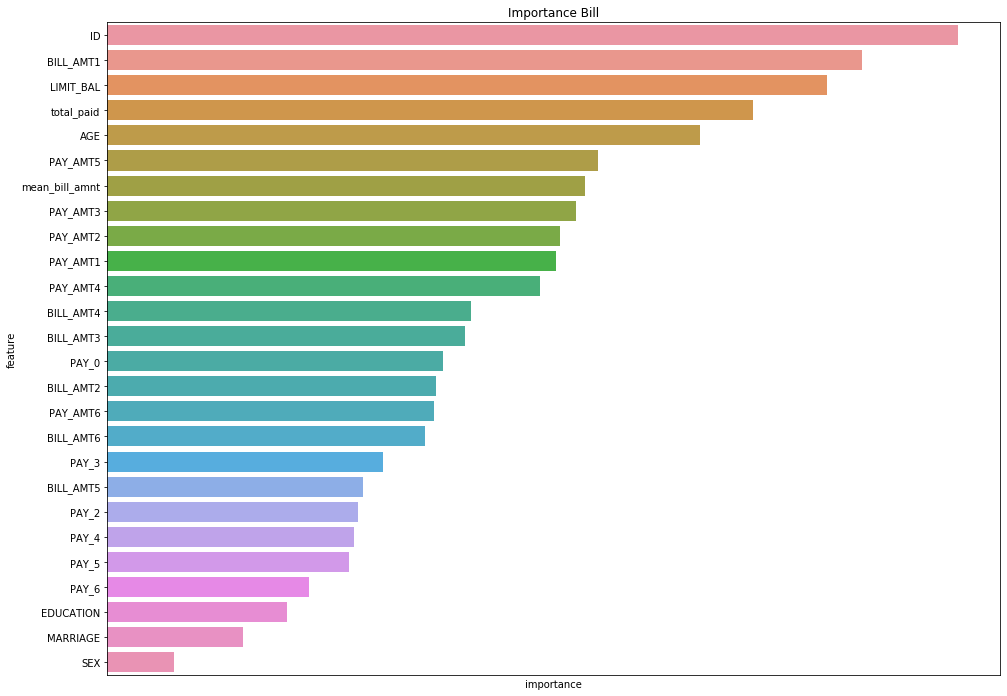

In [47]:
print(calc_accuracy(y_pred_train, y_train))
print(calc_accuracy(y_pred_test, y_test))
plot_feature_importance(feature_importance, title = 'Importance Bill')

**Exercise:** Try tuning, adding, removing params.
    
See https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [52]:
params_changed = {
          'n_estimators': 500,  # Number of trees
          'num_leaves': 60,  # max number of leaves in tree
          'min_data_in_leaf': 2,
          'max_depth': -1,
            'max_bin': 5,
          'learning_rate': 0.001,
          "boosting": "gbdt",
          "bagging_freq": 10,
          'num_threads': 8,
          "metric": 'binary_logloss',
         }

In [53]:
y_pred_train, y_pred_test, feature_importance = train_lgb(X_train, X_test, y_train, y_test, params=params_changed)

[1]	training's auc: 0.778322	training's binary_logloss: 0.527673	valid_1's auc: 0.767311	valid_1's binary_logloss: 0.530254
Training until validation scores don't improve for 50 rounds
[2]	training's auc: 0.778322	training's binary_logloss: 0.527438	valid_1's auc: 0.767311	valid_1's binary_logloss: 0.530026
[3]	training's auc: 0.778322	training's binary_logloss: 0.527204	valid_1's auc: 0.767311	valid_1's binary_logloss: 0.529799
[4]	training's auc: 0.778322	training's binary_logloss: 0.526971	valid_1's auc: 0.767311	valid_1's binary_logloss: 0.529573
[5]	training's auc: 0.778363	training's binary_logloss: 0.526738	valid_1's auc: 0.767374	valid_1's binary_logloss: 0.529347
[6]	training's auc: 0.778364	training's binary_logloss: 0.526506	valid_1's auc: 0.767378	valid_1's binary_logloss: 0.529122
[7]	training's auc: 0.778509	training's binary_logloss: 0.526275	valid_1's auc: 0.767376	valid_1's binary_logloss: 0.528898
[8]	training's auc: 0.778526	training's binary_logloss: 0.526045	valid_

[68]	training's auc: 0.78061	training's binary_logloss: 0.513398	valid_1's auc: 0.769604	valid_1's binary_logloss: 0.516528
[69]	training's auc: 0.780585	training's binary_logloss: 0.513204	valid_1's auc: 0.769653	valid_1's binary_logloss: 0.516344
[70]	training's auc: 0.780575	training's binary_logloss: 0.513012	valid_1's auc: 0.769673	valid_1's binary_logloss: 0.516158
[71]	training's auc: 0.780583	training's binary_logloss: 0.512819	valid_1's auc: 0.769684	valid_1's binary_logloss: 0.515974
[72]	training's auc: 0.780745	training's binary_logloss: 0.512628	valid_1's auc: 0.769658	valid_1's binary_logloss: 0.515791
[73]	training's auc: 0.780737	training's binary_logloss: 0.512436	valid_1's auc: 0.769735	valid_1's binary_logloss: 0.515607
[74]	training's auc: 0.780697	training's binary_logloss: 0.512245	valid_1's auc: 0.769766	valid_1's binary_logloss: 0.515425
[75]	training's auc: 0.780663	training's binary_logloss: 0.512055	valid_1's auc: 0.76976	valid_1's binary_logloss: 0.515242
[7

[136]	training's auc: 0.783079	training's binary_logloss: 0.501338	valid_1's auc: 0.772894	valid_1's binary_logloss: 0.504957
[137]	training's auc: 0.783055	training's binary_logloss: 0.501177	valid_1's auc: 0.772885	valid_1's binary_logloss: 0.504802
[138]	training's auc: 0.783068	training's binary_logloss: 0.501015	valid_1's auc: 0.772882	valid_1's binary_logloss: 0.504645
[139]	training's auc: 0.783077	training's binary_logloss: 0.500854	valid_1's auc: 0.772886	valid_1's binary_logloss: 0.50449
[140]	training's auc: 0.783103	training's binary_logloss: 0.500693	valid_1's auc: 0.772889	valid_1's binary_logloss: 0.504336
[141]	training's auc: 0.783116	training's binary_logloss: 0.500532	valid_1's auc: 0.772916	valid_1's binary_logloss: 0.504181
[142]	training's auc: 0.783128	training's binary_logloss: 0.500372	valid_1's auc: 0.772955	valid_1's binary_logloss: 0.504027
[143]	training's auc: 0.783124	training's binary_logloss: 0.500212	valid_1's auc: 0.773006	valid_1's binary_logloss: 0.

[202]	training's auc: 0.787188	training's binary_logloss: 0.491424	valid_1's auc: 0.775717	valid_1's binary_logloss: 0.495415
[203]	training's auc: 0.787183	training's binary_logloss: 0.491285	valid_1's auc: 0.775777	valid_1's binary_logloss: 0.495282
[204]	training's auc: 0.787257	training's binary_logloss: 0.491146	valid_1's auc: 0.775736	valid_1's binary_logloss: 0.495147
[205]	training's auc: 0.787273	training's binary_logloss: 0.491008	valid_1's auc: 0.775721	valid_1's binary_logloss: 0.495017
[206]	training's auc: 0.787288	training's binary_logloss: 0.49087	valid_1's auc: 0.775782	valid_1's binary_logloss: 0.494883
[207]	training's auc: 0.787265	training's binary_logloss: 0.490733	valid_1's auc: 0.775775	valid_1's binary_logloss: 0.494751
[208]	training's auc: 0.7873	training's binary_logloss: 0.490595	valid_1's auc: 0.775811	valid_1's binary_logloss: 0.49462
[209]	training's auc: 0.787314	training's binary_logloss: 0.490458	valid_1's auc: 0.775773	valid_1's binary_logloss: 0.494

[271]	training's auc: 0.790561	training's binary_logloss: 0.482458	valid_1's auc: 0.776689	valid_1's binary_logloss: 0.486857
[272]	training's auc: 0.790574	training's binary_logloss: 0.482338	valid_1's auc: 0.77672	valid_1's binary_logloss: 0.48674
[273]	training's auc: 0.790578	training's binary_logloss: 0.482216	valid_1's auc: 0.776689	valid_1's binary_logloss: 0.486627
[274]	training's auc: 0.790725	training's binary_logloss: 0.482094	valid_1's auc: 0.776804	valid_1's binary_logloss: 0.486513
[275]	training's auc: 0.790793	training's binary_logloss: 0.481971	valid_1's auc: 0.776831	valid_1's binary_logloss: 0.486399
[276]	training's auc: 0.790852	training's binary_logloss: 0.481848	valid_1's auc: 0.776891	valid_1's binary_logloss: 0.486286
[277]	training's auc: 0.790911	training's binary_logloss: 0.481726	valid_1's auc: 0.776921	valid_1's binary_logloss: 0.486173
[278]	training's auc: 0.790996	training's binary_logloss: 0.481604	valid_1's auc: 0.77693	valid_1's binary_logloss: 0.48

[337]	training's auc: 0.793554	training's binary_logloss: 0.474867	valid_1's auc: 0.778153	valid_1's binary_logloss: 0.479901
[338]	training's auc: 0.793606	training's binary_logloss: 0.474759	valid_1's auc: 0.778136	valid_1's binary_logloss: 0.479805
[339]	training's auc: 0.793652	training's binary_logloss: 0.474651	valid_1's auc: 0.778164	valid_1's binary_logloss: 0.479707
[340]	training's auc: 0.793678	training's binary_logloss: 0.474544	valid_1's auc: 0.778174	valid_1's binary_logloss: 0.479611
[341]	training's auc: 0.793715	training's binary_logloss: 0.474436	valid_1's auc: 0.778132	valid_1's binary_logloss: 0.479515
[342]	training's auc: 0.793753	training's binary_logloss: 0.474329	valid_1's auc: 0.778146	valid_1's binary_logloss: 0.479416
[343]	training's auc: 0.793765	training's binary_logloss: 0.474222	valid_1's auc: 0.778124	valid_1's binary_logloss: 0.479321
[344]	training's auc: 0.793769	training's binary_logloss: 0.474115	valid_1's auc: 0.778116	valid_1's binary_logloss: 0

[405]	training's auc: 0.795196	training's binary_logloss: 0.467982	valid_1's auc: 0.778173	valid_1's binary_logloss: 0.473703
[406]	training's auc: 0.795214	training's binary_logloss: 0.467887	valid_1's auc: 0.778164	valid_1's binary_logloss: 0.473618
[407]	training's auc: 0.795248	training's binary_logloss: 0.467792	valid_1's auc: 0.778197	valid_1's binary_logloss: 0.473533
[408]	training's auc: 0.795267	training's binary_logloss: 0.467697	valid_1's auc: 0.77822	valid_1's binary_logloss: 0.473449
[409]	training's auc: 0.795292	training's binary_logloss: 0.467604	valid_1's auc: 0.77821	valid_1's binary_logloss: 0.473364
[410]	training's auc: 0.795316	training's binary_logloss: 0.467509	valid_1's auc: 0.778218	valid_1's binary_logloss: 0.473279
[411]	training's auc: 0.795341	training's binary_logloss: 0.467415	valid_1's auc: 0.778169	valid_1's binary_logloss: 0.473194
[412]	training's auc: 0.795342	training's binary_logloss: 0.467321	valid_1's auc: 0.778174	valid_1's binary_logloss: 0.4

[472]	training's auc: 0.796522	training's binary_logloss: 0.461984	valid_1's auc: 0.778211	valid_1's binary_logloss: 0.468366
[473]	training's auc: 0.796545	training's binary_logloss: 0.461901	valid_1's auc: 0.778215	valid_1's binary_logloss: 0.468293
[474]	training's auc: 0.796571	training's binary_logloss: 0.461817	valid_1's auc: 0.778201	valid_1's binary_logloss: 0.468219
[475]	training's auc: 0.796589	training's binary_logloss: 0.461733	valid_1's auc: 0.778191	valid_1's binary_logloss: 0.468144
[476]	training's auc: 0.796604	training's binary_logloss: 0.46165	valid_1's auc: 0.778178	valid_1's binary_logloss: 0.468073
[477]	training's auc: 0.79663	training's binary_logloss: 0.461566	valid_1's auc: 0.778179	valid_1's binary_logloss: 0.467998
[478]	training's auc: 0.796652	training's binary_logloss: 0.461484	valid_1's auc: 0.778178	valid_1's binary_logloss: 0.467926
[479]	training's auc: 0.796674	training's binary_logloss: 0.4614	valid_1's auc: 0.778218	valid_1's binary_logloss: 0.467

0.7792083333333333
0.7771666666666667


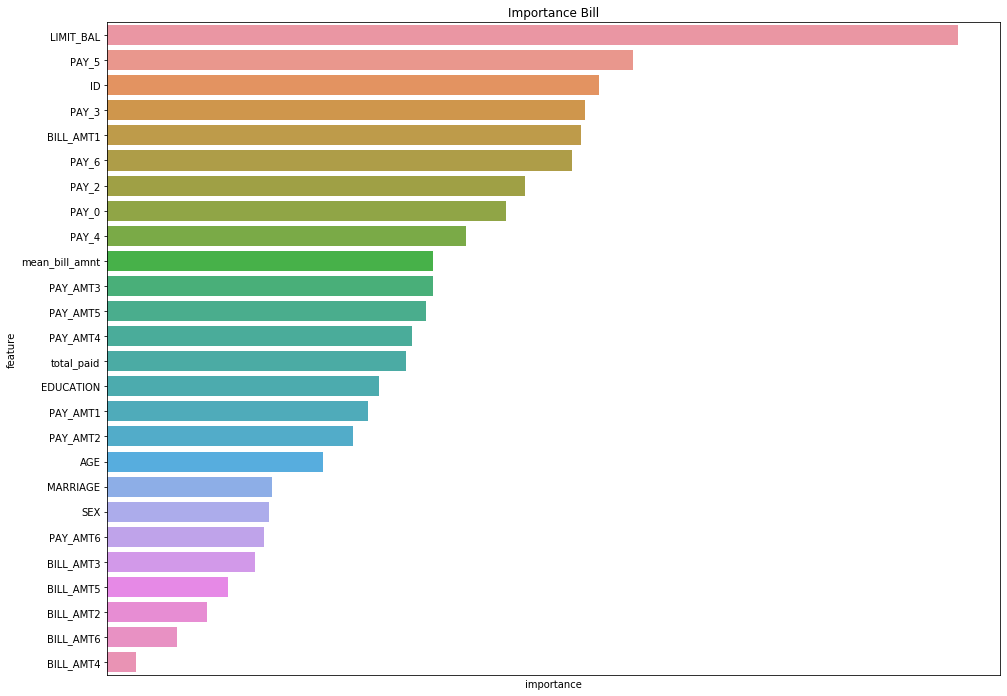

In [54]:
print(calc_accuracy(y_pred_train, y_train))
print(calc_accuracy(y_pred_test, y_test))
plot_feature_importance(feature_importance, title = 'Importance Bill')

**Exercise:** Try creating new features, or removing unimportant features

In [60]:
X = X.drop(columns=["ID", "SEX", 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'])

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
y_pred_train, y_pred_test, feature_importance = train_lgb(X_train, X_test, y_train, y_test, params=params)

[1]	training's auc: 0.776759	training's binary_logloss: 0.523194	valid_1's auc: 0.758976	valid_1's binary_logloss: 0.525995
Training until validation scores don't improve for 50 rounds
[2]	training's auc: 0.780682	training's binary_logloss: 0.518733	valid_1's auc: 0.763126	valid_1's binary_logloss: 0.521808
[3]	training's auc: 0.781466	training's binary_logloss: 0.514543	valid_1's auc: 0.76543	valid_1's binary_logloss: 0.517849
[4]	training's auc: 0.782655	training's binary_logloss: 0.510595	valid_1's auc: 0.766354	valid_1's binary_logloss: 0.51414
[5]	training's auc: 0.785489	training's binary_logloss: 0.506779	valid_1's auc: 0.770689	valid_1's binary_logloss: 0.510549
[6]	training's auc: 0.790204	training's binary_logloss: 0.503181	valid_1's auc: 0.773703	valid_1's binary_logloss: 0.507163
[7]	training's auc: 0.792224	training's binary_logloss: 0.499805	valid_1's auc: 0.775133	valid_1's binary_logloss: 0.503914
[8]	training's auc: 0.793312	training's binary_logloss: 0.496559	valid_1'

[70]	training's auc: 0.830711	training's binary_logloss: 0.412585	valid_1's auc: 0.78091	valid_1's binary_logloss: 0.435779
[71]	training's auc: 0.831464	training's binary_logloss: 0.411961	valid_1's auc: 0.780872	valid_1's binary_logloss: 0.435562
[72]	training's auc: 0.832275	training's binary_logloss: 0.411343	valid_1's auc: 0.780607	valid_1's binary_logloss: 0.435379
[73]	training's auc: 0.832839	training's binary_logloss: 0.410778	valid_1's auc: 0.780542	valid_1's binary_logloss: 0.435175
[74]	training's auc: 0.83352	training's binary_logloss: 0.41018	valid_1's auc: 0.780367	valid_1's binary_logloss: 0.434976
[75]	training's auc: 0.834242	training's binary_logloss: 0.409564	valid_1's auc: 0.780683	valid_1's binary_logloss: 0.434679
[76]	training's auc: 0.834892	training's binary_logloss: 0.408976	valid_1's auc: 0.780989	valid_1's binary_logloss: 0.434377
[77]	training's auc: 0.835585	training's binary_logloss: 0.408399	valid_1's auc: 0.781031	valid_1's binary_logloss: 0.434144
[78

[136]	training's auc: 0.860247	training's binary_logloss: 0.383844	valid_1's auc: 0.782903	valid_1's binary_logloss: 0.428852
[137]	training's auc: 0.860744	training's binary_logloss: 0.383501	valid_1's auc: 0.782792	valid_1's binary_logloss: 0.428839
[138]	training's auc: 0.861131	training's binary_logloss: 0.383156	valid_1's auc: 0.782755	valid_1's binary_logloss: 0.428807
[139]	training's auc: 0.861467	training's binary_logloss: 0.382794	valid_1's auc: 0.78273	valid_1's binary_logloss: 0.42881
[140]	training's auc: 0.861857	training's binary_logloss: 0.382482	valid_1's auc: 0.782769	valid_1's binary_logloss: 0.428762
[141]	training's auc: 0.862241	training's binary_logloss: 0.382134	valid_1's auc: 0.782775	valid_1's binary_logloss: 0.428739
[142]	training's auc: 0.862518	training's binary_logloss: 0.381812	valid_1's auc: 0.782725	valid_1's binary_logloss: 0.428745
[143]	training's auc: 0.862803	training's binary_logloss: 0.381497	valid_1's auc: 0.782697	valid_1's binary_logloss: 0.4

[204]	training's auc: 0.880958	training's binary_logloss: 0.364353	valid_1's auc: 0.782679	valid_1's binary_logloss: 0.428907
[205]	training's auc: 0.88128	training's binary_logloss: 0.364046	valid_1's auc: 0.782814	valid_1's binary_logloss: 0.428825
[206]	training's auc: 0.881592	training's binary_logloss: 0.363782	valid_1's auc: 0.782778	valid_1's binary_logloss: 0.428849
[207]	training's auc: 0.88195	training's binary_logloss: 0.363519	valid_1's auc: 0.782625	valid_1's binary_logloss: 0.428936
[208]	training's auc: 0.882204	training's binary_logloss: 0.363275	valid_1's auc: 0.782561	valid_1's binary_logloss: 0.428969
[209]	training's auc: 0.882467	training's binary_logloss: 0.363005	valid_1's auc: 0.782617	valid_1's binary_logloss: 0.428945
[210]	training's auc: 0.88275	training's binary_logloss: 0.362756	valid_1's auc: 0.782579	valid_1's binary_logloss: 0.428956
[211]	training's auc: 0.883172	training's binary_logloss: 0.362441	valid_1's auc: 0.782551	valid_1's binary_logloss: 0.42

0.835875
0.82


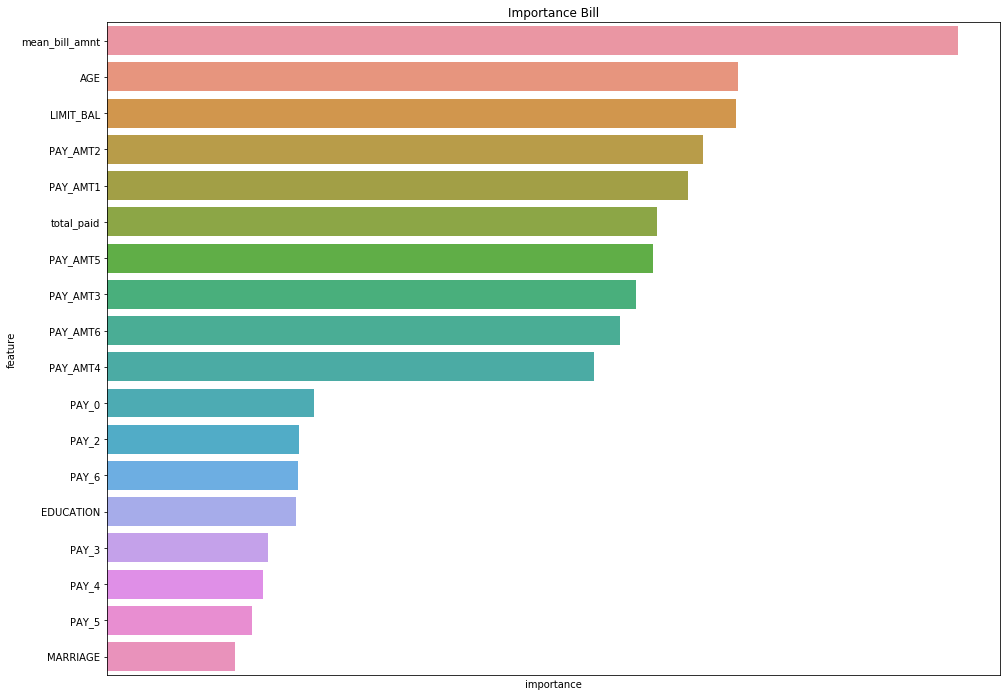

In [62]:
print(calc_accuracy(y_pred_train, y_train))
print(calc_accuracy(y_pred_test, y_test))
plot_feature_importance(feature_importance, title = 'Importance Bill')